<a href="https://colab.research.google.com/github/brianp0513/NLP-project/blob/main/CNN_LSTM_NLP_Project_version1_with_K_fold_Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
import time
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import random
import os
import tensorflow as tf

In [3]:
def getTextFromFiles(df, data_path, depression, limit):
    """Return Data Frame """

    for file in os.listdir(data_path)[:limit]:
        with open(data_path + "/" + file, 'r', encoding="ISO-8859-1") as file1:
            file1 = file1.read()
            df = df.append({'text': file1, 'depression': int(depression)}, ignore_index=True)

    return df


In [4]:
data_path_d = "/content/drive/My Drive/NLP Team/code/kerasData/reddit_depression"
data_path_nd = "/content/drive/My Drive/NLP Team/code/kerasData/reddit_non_depression"
df = pd.DataFrame(columns=['text', 'depression'])
df = getTextFromFiles(df, data_path_d, 1, 500)
df = getTextFromFiles(df, data_path_nd, 0, 500)

In [7]:

def RNN(model):

  model.add(tf.keras.layers.Embedding(max_words,50,input_length=max_len))
  model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.LSTM(64))
  # model.add(tf.keras.layers.Dense(256))
  # model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(1))
  model.add(tf.keras.layers.Activation('sigmoid'))
  model.build(input_shape=sequences_matrix.shape)

  return model


5-Fold Cross Validation

In [12]:
from sklearn.model_selection import KFold
import numpy as np

# Input Data
X = df['text'].to_numpy()
Y = df['depression'].to_numpy().astype(float)

max_words = 1000
max_len = 150

batch_size = 4
no_epochs = 10
verbosity = 0

num_folds = 5

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
# inputs = np.concatenate((X_train, X_test), axis=0)
# targets = np.concatenate((Y_train, Y_test), axis=0)

inputs = X
targets = Y
history = None
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Data format matching
  tok = Tokenizer(num_words=max_words)
  tok.fit_on_texts(inputs[train])
  sequences = tok.texts_to_sequences(inputs[train])
  sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

  # Define the model architecture
  model = tf.keras.models.Sequential()
  model = RNN(model)
  # model.summary()
  model.build(input_shape=sequences_matrix.shape)
  # Compile the model
  model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
  
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  # Fit data to model
  history = model.fit(sequences_matrix, targets[train], batch_size=batch_size, epochs=no_epochs, verbose=verbosity)
  
  # Data format matching
  test_sequences = tok.texts_to_sequences(inputs[test])
  test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
  

  # Generate generalization metrics
  # accr = model.evaluate(test_sequences_matrix,Y_test)
  # print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

  scores = model.evaluate(test_sequences_matrix, targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.4182265102863312; accuracy of 88.99999856948853%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.674246072769165; accuracy of 87.99999952316284%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.5344391465187073; accuracy of 85.50000190734863%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.6244663000106812; accuracy of 88.99999856948853%
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.622851550579071; accuracy of 85.50000190734863%
------------------------------------------------------------------------
Score per fold
--------------------------------------------

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

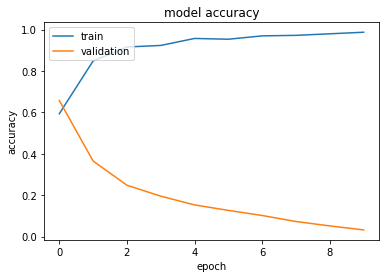

In [17]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()